In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.model_selection import cross_val_score
import re
from scipy import stats
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import time
from datetime import datetime

In [2]:
df2 = pd.read_json("./dataset/train.json")

In [3]:
# Remove Outliers and Drop Empty Fields
newdf2 = df2[(df2['description'] != '') & (df2['description'] != '<p><a  website_redacted')]
newdf2 = newdf2[newdf2['display_address'] != '']
newdf2 = newdf2[newdf2['features'].str.len() > 0]
newdf2 = newdf2[(newdf2['interest_level'] == 'low') | (newdf2['interest_level'] == 'medium') | (newdf2['interest_level'] == 'high')]
newdf2 = newdf2[(newdf2['price'] != 10) & (newdf2['price'] != 0)]
newdf2 = newdf2[newdf2['latitude'] != 0]
newdf2 = newdf2[newdf2['longitude'] != 0]
newdf2 = newdf2[newdf2['photos'].str.len() > 0]
newdf2 = newdf2[newdf2['street_address'].str.len() > 0]

newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bathrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bedrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['latitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['longitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['price'])) < 3)]

In [4]:
def convert_dt_numeric(dataframe):
    datetime_float = []
    dct = {}
    indexes = list(dataframe.index.values.tolist())
    text_features_count = []
    
    for index in indexes:
        # counting total # of features
        if 'features' in dataframe:
            values = list(dataframe['features'][index])
            text_features_count.append(len(values))
        
        # converting time to float
        if 'created' in dataframe:
            datetime_obj = datetime.strptime(dataframe['created'][index], '%Y-%m-%d %H:%M:%S') 
            datetime_sec = time.mktime(datetime_obj.timetuple())
            datetime_float.append(datetime_sec)
    #     Convert float to datetime obj
    #     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
    #     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
    #     print(type(datetime_sec)) // float
    # dct
    if 'features' in dataframe:
        dataframe['text_features_count'] = text_features_count
    if 'created' in dataframe:
        dataframe['datetime_float'] = datetime_float

    # label interest_level => row : 2, medium : 1, high : 0
    if 'interest_level' in dataframe:
        lb_make = LabelEncoder()
        dataframe["interest_level_code"] = lb_make.fit_transform(dataframe["interest_level"])
    
    # Count total # of photos for each listing
    if 'photos' in dataframe:
        dataframe['num_photos'] = dataframe['photos'].apply(len)
    if 'bathrooms' and 'bedrooms' in dataframe:
        dataframe['total_rooms'] = dataframe['bathrooms'] + dataframe['bedrooms']

In [5]:
convert_dt_numeric(newdf2)

In [6]:
df_numeric = newdf2.copy(deep=True)
# df_numeric.drop(['latitude', 'building_id','created','features', 'interest_level','longitude', 'description', 'display_address', 
#                       'listing_id', 'manager_id', 'photos', 'street_address'], axis = 1, inplace= True)

# # plt.figure(figsize=(7,4))
# # sns.heatmap(df_numeric.corr(), annot=True, cmap='cubehelix_r')
# # plt.show()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40811 entries, 4 to 124009
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bathrooms            40811 non-null  float64
 1   bedrooms             40811 non-null  int64  
 2   building_id          40811 non-null  object 
 3   created              40811 non-null  object 
 4   description          40811 non-null  object 
 5   display_address      40811 non-null  object 
 6   features             40811 non-null  object 
 7   latitude             40811 non-null  float64
 8   listing_id           40811 non-null  int64  
 9   longitude            40811 non-null  float64
 10  manager_id           40811 non-null  object 
 11  photos               40811 non-null  object 
 12  price                40811 non-null  int64  
 13  street_address       40811 non-null  object 
 14  interest_level       40811 non-null  object 
 15  text_features_count  40811 non-null

### Feature Selection by Feature Importance

[0.00857035 0.15913872 0.15689368 0.01551847 0.21969692 0.11406464
 0.19857812 0.11362818 0.01391091]


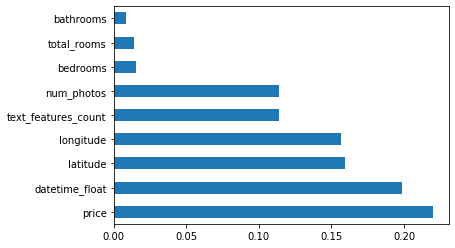

In [7]:
X = df_numeric[['bathrooms','latitude', 'longitude', 'bedrooms', 'price', 'text_features_count', 'datetime_float', 'num_photos', 'total_rooms']]  #independent columns
y = df_numeric['interest_level_code'] 


from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Feature Selection by Chi2

In [8]:
X = df_numeric[['bathrooms', 'bedrooms', 'price', 'text_features_count', 'datetime_float', 'num_photos', 'total_rooms']]  #independent columns
y = df_numeric['interest_level_code'] 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best featur

                 Specs         Score
2                price  1.128768e+06
4       datetime_float  5.420127e+04
3  text_features_count  4.252944e+02
1             bedrooms  1.553803e+02
5           num_photos  9.519041e+01
6          total_rooms  5.618073e+01
0            bathrooms  1.720792e+01


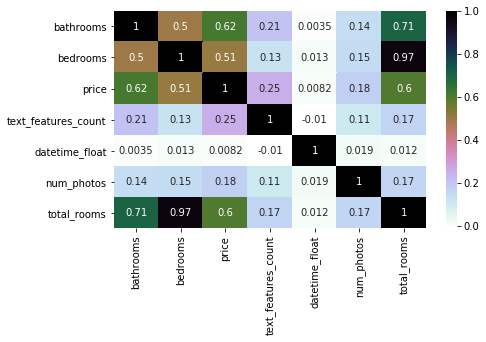

In [9]:
plt.figure(figsize=(7,4))
sns.heatmap(X.corr(), annot=True, cmap='cubehelix_r')
plt.show()

In [10]:
testDT = pd.read_json("./dataset/test.json") # no interest level. Original
testDT.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street


In [11]:
convert_dt_numeric(testDT)

In [12]:
testDT.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,text_features_count,datetime_float,num_photos,total_rooms
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street,6,1.465648e+09,8,2.0


# K Nearest Neighbour

### Test Dataset

In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Train model with trainset first and make prediction based on trainset
X = df_numeric[['price','datetime_float', 'total_rooms', 'latitude', 'longitude']]
y = df_numeric[['interest_level_code']]
test_X = testDT[['price','datetime_float', 'total_rooms', 'latitude', 'longitude']]

K = np.sqrt(test_X.shape[0])
# print(K)
knn = KNeighborsClassifier(n_neighbors=80)

model.fit(X, np.ravel(y))
model_scores = model.score(X, y)

print("Accuracy: %0.2f (+/- %0.2f)" % (model_scores.mean(), model_scores.std() * 2))

Accuracy: 1.00 (+/- 0.00)


### K-Fold Cross-Validation Datasets

In [165]:
# kf = KFold(n_splits=10, shuffle=True)
skf = StratifiedKFold(n_splits=5)
scores = []

# for train_index, test_index in skf.split(initial_train_X,initial_train_y):
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index[0]:train_index[-1]], X[test_index[0]:test_index[-1]]
    y_train, y_test = y[train_index[0]:train_index[-1]], y[test_index[0]:test_index[-1]]

    model.fit(X_train, np.ravel(y_train))
    scores.append(model.score(X_test, y_test))
    print('done fitting...')
    
print("Accuracy:",np.mean(scores)," +/-",np.std(scores)*2)
# print(model.best_score_)
# print(model.best_params_)


done fitting...
done fitting...
done fitting...
done fitting...
done fitting...
Accuracy: 0.8781917983632708  +/- 0.29590282936882206


Confusion matrix, without normalization
[[ 159  289  192]
 [ 108 5135  596]
 [ 140 1320  656]]
Normalized confusion matrix
[[0.25 0.45 0.3 ]
 [0.02 0.88 0.1 ]
 [0.07 0.62 0.31]]


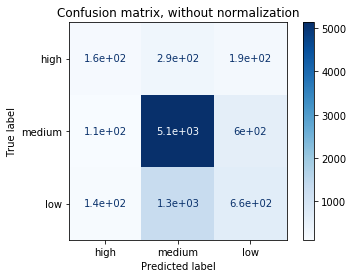

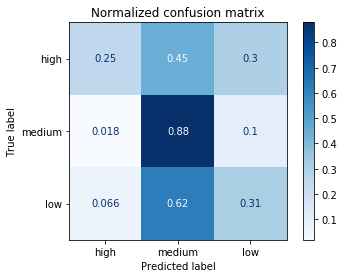

In [166]:
from sklearn.metrics import plot_confusion_matrix


# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=["high", "medium", "low"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


plt.show()
    

In [167]:
from sklearn.metrics import log_loss

probs_labels = model.predict_proba(X_test) # output: [[p1,p2,p3],[p1,p2,p3]...]
log_loss(y_test, probs_labels)

0.9564816806498976

In [155]:
predicted = model.predict(test_X) 
probs_labels = model.predict_proba(test_X) # output: [[p1,p2,p3],[p1,p2,p3]...]

df_with_ps = testDT.copy(deep=True)
df_with_ps['p_0_interest'] = [probs[0] for probs in probs_labels]
df_with_ps['p_1_interest'] = [probs[1] for probs in probs_labels]
df_with_ps['p_2_interest'] = [probs[2] for probs in probs_labels]
df_with_ps['predicted'] = predicted

df_with_ps.rename(columns={'p_0_interest': 'high', 'p_1_interest': 'medium', 'p_2_interest': 'low'}, inplace=True)
df2csv = df_with_ps[['listing_id', 'high', 'medium','low']]
# df2csv.head(5)
df2csv.to_csv('kaggleTest.csv', encoding='utf-8', index=False)
print('done exporting csv...')

done exporting csv...
